# Check GPU options

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3792772836009983788
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3059115623
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17953228386975239980
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


# Import needed libraries

In [23]:
# Import general purpose python libraries
import os
from matplotlib import pyplot
from PIL import Image # For handling the images
import numpy as np
from sklearn import metrics
import pandas as pd
# Import different Keras functionalities
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
#from tensorflow.keras.optimizers import SGD,Adagrad
from keras.optimizers import SGD,Adagrad
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
#from keras.applications import ResNet50,Xception,VGG16,VGG19
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from plotcm import plotcm

####
# Where to save the figures
IMAGES_PATH = "../images"
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        pyplot.tight_layout()
    pyplot.savefig(path, format=fig_extension, dpi=resolution)
from utils import saveFigures,write_json,create_json,load_previous_weights

from models import VGG16, MLP_model

# Load data

In [24]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)

X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (40000, 32, 32, 3)


# Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [25]:
from datetime import datetime
# Randomize the initial network 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Directory where to store weights of the model and results
now = datetime.now()
current_time = now.strftime("%d_%H_%M_%S")
experiment_rootdir = "./test/"+current_time+"/"
weights_path = experiment_rootdir +"weights.h5"
weights_best_path = experiment_rootdir +"weights_best.h5"
weights_augmentation_path = experiment_rootdir +"weights_augmentation.h5"
weights_augmentation_best_path = experiment_rootdir +"weights_augmentation_best.h5"
json_path = experiment_rootdir +"experiment.json"

# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)
print(experiment_rootdir)

./test/05_20_12_00/


In [26]:
# Parameters that configures the training process

# Tunable parameters
name_model = "MLP-10layers"
initial_lr = 5e-2

l2_reg = 0.0
dropout = 0.0

compile_parameters = { "metrics": ['accuracy'], "optimizer": SGD(learning_rate=initial_lr)}

# TODO


## Constant parameters
batch_size = 512 
epochs = 200
initial_epoch = 0 
num_classes = 10
dropout = 0.5

checkpoint_cb = ModelCheckpoint(weights_best_path,save_best_only=True)
early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True)
'''
optimizer=  = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
'''

parameters = {
    "name_model":name_model,
    "compile_parameters" :str(compile_parameters) ,
    "batch_size": batch_size,
    "epochs": epochs, 
    "initial_epoch":initial_epoch, 
    "initial_lr": initial_lr,
    "num_classes": num_classes,
    "dropout": dropout

}
create_json({"parameters":parameters}, json_path)


In [27]:
def trainModel(model,compile_parameters,X_train, y_train, validation_data, epochs, batch_size, experiment_rootdir, weights_path, json_path,datagen=None):
    model.compile(loss='categorical_crossentropy', optimizer=compile_parameters['optimizer'], metrics=compile_parameters['metrics'])
    print(model.summary())
    if(datagen is not None):
        history=model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = (len(X_train) //batch_size), epochs=epochs, validation_data=validation_data,validation_steps=(len(X_train)*0.2 //batch_size)
        hist_df = pd.DataFrame(history.history) 
        data = {"train_augmentation_result":hist_df.to_dict()}
    
    else:
        history = model.fit(x= X_train, y= y_train, validation_data = validation_data, epochs = epochs, batch_size= batch_size,callbacks=[checkpoint_cb, early_stopping_cb])
        hist_df = pd.DataFrame(history.history) 
        data = {"train_result":hist_df.to_dict()}

    model.save_weights(weights_path)
    write_json(data,json_path)
    return history

# Training 

In [28]:
#Get model
model = MLP_model(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg= l2_reg,n_hidden=10)
#model = VGG16(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg=l2_reg)

#load weights
load_previous_weights(model,weights_path)

#training model
val = (X_valid, y_valid)

history =trainModel(model,compile_parameters,X_train, y_train,val, epochs, batch_size,experiment_rootdir,weights_path,json_path)

saveFigures(experiment_rootdir, history, "accuracy", "loss")

Impossible to find weight path. Returning untrained model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 940)               2888620   
_________________________________________________________________
dense_2 (Dense)              (None, 846)               796086    
_________________________________________________________________
dense_3 (Dense)              (None, 752)               636944    
_________________________________________________________________
dense_4 (Dense)              (None, 658)               495474    
_________________________________________________________________
d

KeyboardInterrupt: 

In [12]:
#Data augmentation
# set up image augmentation

rotation_range=45
horizontal_flip=True
zoom_range=0.3
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    zoom_range=zoom_range
    )
 
datagen.fit(X_train)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
  print (X_batch.shape)
  for i in range(0,4):
    pyplot.subplot(220 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  break
# train with image augmentation
augmentation_parameters = {
    "rotation_range":str(rotation_range),
    "horizontal_flip":str(horizontal_flip),
    "zoom_range":str(zoom_range)
}
write_json({"augmentation_parameters":augmentation_parameters}, json_path)

SyntaxError: invalid syntax (Temp/ipykernel_8116/121691445.py, line 27)

In [ ]:
#Get model
model = MLP_model(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg= l2_reg,n_hidden=10)
#model = VGG16(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg=l2_reg)

#load weights
load_previous_weights(model,weights_best_path)
checkpoint_cb = ModelCheckpoint(weights_augmentation_best_path,save_best_only=True)
early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True)
#training model
val = datagen.flow(X_valid, y_valid, batch_size=batch_size)

history =trainModel(model,compile_parameters,X_train, y_train,val, epochs, batch_size,experiment_rootdir,weights_augmentation_path,json_path)

saveFigures(experiment_rootdir, history, "accuracy_augmentation", "loss_augmentation")

# Testing

-----------------------------------------------
Evaluation:
Average accuracy =  0.4919
-----------------------------------------------


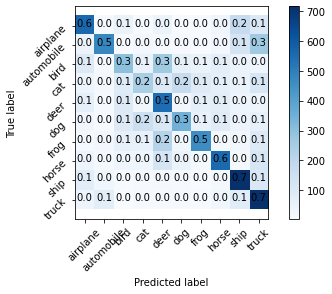

In [8]:
y_pred = np.argmax(model.predict(X_test), axis=1)
gt = np.argmax(y_test, axis=1)

# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, y_pred)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")

# Visualize confusion matrix                                           
plotcm(experiment_rootdir, gt, y_pred,class_names, experiment_rootdir, normalize=True)

data = {"test_accuracy":ave_accuracy}
write_json(data,json_path)

